# Summary
Variance across 1 session over t for the movement path between first and second threshold

### imports:

In [1]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
import scipy.signal as signal

# interpolation because ARDUINO data is spaced unevenly
import scipy.interpolate as interpolate

import pickle # save data
import glob # find files in a directory
import re # regex for string parsing

### set `folder_name`

In [2]:
# for all .mat files in this folder starting with "ToneDisc_ANChandler_p1_" in their name
folder_name = './Joey/Phase1/ToneDisc_ANJoey_p1_'

### sort through relevant .mat files found in folder by day ("_d#")

In [3]:
unsorted_mat_files = glob.glob(folder_name+'*.mat')
sorted_mat_files = sorted(unsorted_mat_files, key=lambda x: int(re.search(r'\d+.mat$',x).group()[:-4]))
sorted_mat_files

['./Joey/Phase1/ToneDisc_ANJoey_p1_d1.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d2.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d3.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d4.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d5.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d6.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d7.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d8.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d9.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d10.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d11.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d12.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d13.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d14.mat']

### extract data from .mat

In [5]:
mat_file_string = sorted_mat_files[-1]
mat_dict = io.loadmat(mat_file_string)

data = mat_dict['data'][0][0]
params = data[0][0][0]
response = data[1][0][0]

### get all movements from trials that meet both thresholds into `extracted_movements`

In [6]:
# get `respMTX` (trials) and `dataArduino` from response
dataArduino = response[0]
#print("dataArduino shape: "+str(dataArduino.shape))
respMTX = response[2]
#print("MTXTrialType shape: "+str(MTXTrialType.shape))
num_trials = respMTX.shape[0]

decision = params[6][0][0][2][0][0]

movements = np.array([]).reshape(0,3)
for trial_i in range(0, num_trials):
    if ~np.isnan(respMTX[trial_i, 1]):
        # get the row in dataArduino for tone_t
        tone_t = respMTX[trial_i, 1]
        for arduino_i, arduino_t in enumerate(dataArduino[:, 0]):
            if tone_t <= arduino_t:
                tone_arduino_i = arduino_i
                break

        # get the row in dataArduino for tone_t
        decision_end_t = tone_t + decision
        for arduino_i, arduino_t in enumerate(dataArduino[:, 0]):
            if decision_end_t <= arduino_t:
                decision_end_arduino_i = arduino_i
                break
        
        # first threshold is just timePressed for now
        first_threshold_arduino_i = 0
        first_threshold = 0
        if ~np.isnan(respMTX[trial_i, 3]):
            for arduino_i, arduino_t in enumerate(dataArduino[:, 0]):
                if respMTX[trial_i, 3] <= arduino_t:
                    first_threshold_arduino_i = arduino_i
                    first_threshold = dataArduino[first_threshold_arduino_i, 1]
                    break
        
        # second threshold for now
        second_threshold_arduino_i = 0
        if first_threshold != 0:
            second_threshold = first_threshold-0.2
            for arduino_i, arduino_data in enumerate(dataArduino[\
                first_threshold_arduino_i:decision_end_arduino_i, 1]):
                if second_threshold >= arduino_data:
                    second_threshold_arduino_i = arduino_i + first_threshold_arduino_i
                    break
        
        # if both first threshold and second threshold are met, add to movements
        if (first_threshold_arduino_i != 0) and (second_threshold_arduino_i !=0):
            print("adding movement from trial: ",trial_i)
            movements = np.vstack((movements, np.array([trial_i, \
                first_threshold_arduino_i, \
                second_threshold_arduino_i]) \
                ))
        


adding movement from trial:  2
adding movement from trial:  4
adding movement from trial:  8
adding movement from trial:  13
adding movement from trial:  20
adding movement from trial:  21
adding movement from trial:  27
adding movement from trial:  28
adding movement from trial:  33
adding movement from trial:  36
adding movement from trial:  49
adding movement from trial:  57
adding movement from trial:  62
adding movement from trial:  63
adding movement from trial:  67
adding movement from trial:  73
adding movement from trial:  84
adding movement from trial:  98
adding movement from trial:  99
adding movement from trial:  112
adding movement from trial:  113
adding movement from trial:  123
adding movement from trial:  125
adding movement from trial:  137
adding movement from trial:  141
adding movement from trial:  149
adding movement from trial:  151
adding movement from trial:  155
adding movement from trial:  157
adding movement from trial:  164
adding movement from trial:  171

### check `movements`

In [7]:
print("number of extracted_movements ", len(movements))
print(movements)

number of extracted_movements  42
[[2.00000e+00 5.04400e+03 5.05900e+03]
 [4.00000e+00 1.47580e+04 1.47650e+04]
 [8.00000e+00 2.70430e+04 2.70810e+04]
 [1.30000e+01 3.97190e+04 3.97260e+04]
 [2.00000e+01 7.48320e+04 7.48420e+04]
 [2.10000e+01 7.60510e+04 7.60790e+04]
 [2.70000e+01 8.84910e+04 8.84990e+04]
 [2.80000e+01 8.96890e+04 8.96910e+04]
 [3.30000e+01 9.58130e+04 9.58160e+04]
 [3.60000e+01 1.19057e+05 1.19070e+05]
 [4.90000e+01 1.49618e+05 1.49641e+05]
 [5.70000e+01 1.68776e+05 1.68784e+05]
 [6.20000e+01 1.86394e+05 1.86407e+05]
 [6.30000e+01 1.89912e+05 1.89921e+05]
 [6.70000e+01 2.03865e+05 2.03876e+05]
 [7.30000e+01 2.10441e+05 2.10454e+05]
 [8.40000e+01 2.28588e+05 2.28629e+05]
 [9.80000e+01 2.49865e+05 2.49875e+05]
 [9.90000e+01 2.51352e+05 2.51353e+05]
 [1.12000e+02 2.70762e+05 2.70773e+05]
 [1.13000e+02 2.72102e+05 2.72117e+05]
 [1.23000e+02 3.00098e+05 3.00114e+05]
 [1.25000e+02 3.03917e+05 3.03928e+05]
 [1.37000e+02 3.20599e+05 3.20608e+05]
 [1.41000e+02 3.26098e+05 3.26

### remove baselines and align temporally for each `movement` in `extracted_movements` and put into `extracted_movements_dataArduino`
`extracted_movements_dataArduino`: list where first elem is times and second elem is mvts


Text(0, 0.5, 'change in V (displacement)')

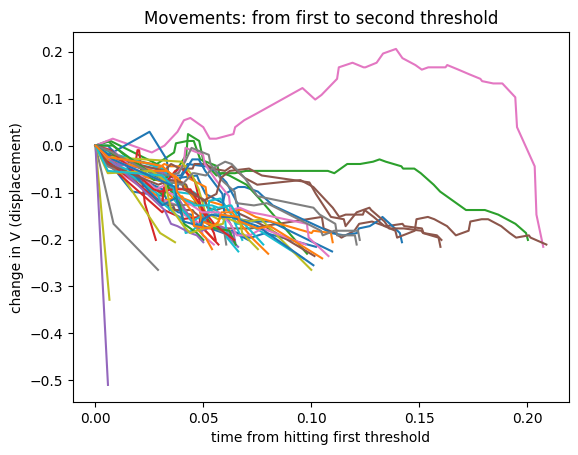

In [8]:
movements_dataArduino = []
for movement in movements:
    movements_dataArduino.append([
        dataArduino[int(movement[1]):int(movement[2])+1,0]-dataArduino[int(movement[1]),0],\
        dataArduino[int(movement[1]):int(movement[2])+1,1] - dataArduino[int(movement[1]), 1]\
            ])
    # also check by plotting all of the movements
    plt.plot(\
        dataArduino[int(movement[1]):int(movement[2])+1,0]-dataArduino[int(movement[1]),0],\
        dataArduino[int(movement[1]):int(movement[2])+1,1] - dataArduino[int(movement[1]), 1]\
        )
plt.title("Movements: from first to second threshold")
plt.xlabel("time from hitting first threshold")
plt.ylabel("change in V (displacement)")

In [9]:
movements_dataArduino[0]

[array([0.       , 0.0170462, 0.0323965, 0.033302 , 0.0343383, 0.0354424,
        0.0383531, 0.0443343, 0.0473333, 0.0563064, 0.0622881, 0.0630955,
        0.0712625, 0.0720695, 0.0787825, 0.1021822]),
 array([ 0.    , -0.098 , -0.1078, -0.1225, -0.1372, -0.1323, -0.1421,
        -0.147 , -0.1666, -0.1813, -0.1911, -0.1813, -0.196 , -0.196 ,
        -0.1862, -0.2156])]

### linear interpolation fcn:
- takes `oldx`, `oldy`, `num_samples`
- returns `newx`, `newy`

In [10]:
def interpolate_dataArduino(oldx, oldy, num_samples):
    f = interpolate.interp1d(oldx, oldy, kind='linear')
    newx = np.linspace(min(oldx), max(oldx), num_samples)
    newy = f(newx)
    return newx, newy

### interpolate `movement_dataArduinos` from `movements_dataArduino` and store in `interpolated_movements_dataArduino`

In [11]:
num_samples = 100
interpolated_movements_dataArduino=np.array([]).reshape(0,num_samples)
for movement_dataArduino in movements_dataArduino:
    _, interpolated_movement_dataArduino = interpolate_dataArduino(movement_dataArduino[0], movement_dataArduino[1], num_samples)
    interpolated_movements_dataArduino = np.vstack((\
        interpolated_movements_dataArduino, interpolated_movement_dataArduino\
            ))

### Plot the movements across % movement completed

Text(0.5, 1.0, 'Movement paths from first to second threshold (1 day)')

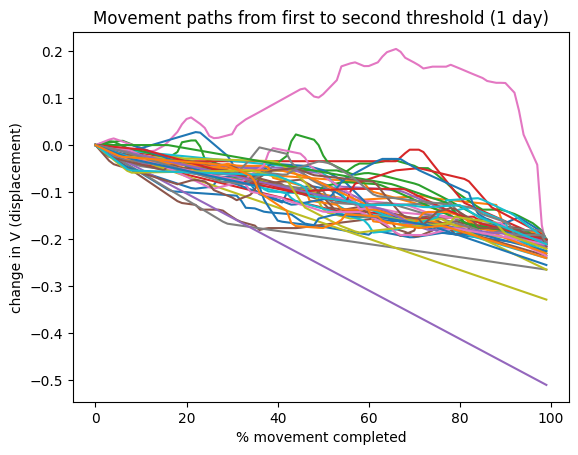

In [12]:
for interpolated_movement_dataArduino in interpolated_movements_dataArduino:
    plt.plot(range(0,100), interpolated_movement_dataArduino)

plt.xlabel("% movement completed")
plt.ylabel("change in V (displacement)")
plt.title("Movement paths from first to second threshold (1 day)")

### calculate the variance across each `interpolated_movement_dataArduino`

In [13]:
movements_vars=np.var(interpolated_movements_dataArduino, axis=0)

Text(0.5, 1.0, 'Variance of movement paths from first to second threshold (1 day)')

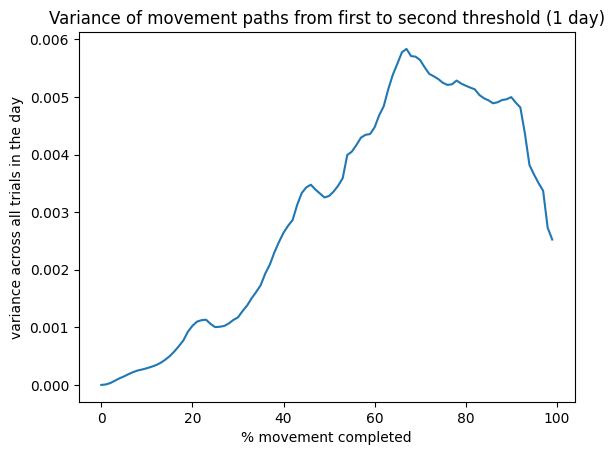

In [14]:
plt.plot(range(0,100), movements_vars)
plt.xlabel("% movement completed")
plt.ylabel("variance across all trials in the day")
plt.title("Variance of movement paths from first to second threshold (1 day)")

### save `movements_dataArduino`, `interpolated_movements_dataArduino` and `movements_vars`

In [15]:
file = open(mat_file_string+'_interpolated_movements_dataArduino.pickle', 'wb')
pickle.dump(interpolated_movements_dataArduino, file)
file.close()

file = open(mat_file_string+'_movements_dataArduino.pickle', 'wb')
pickle.dump(movements_dataArduino, file)
file.close()

file = open(mat_file_string+'_movements_vars.pickle', 'wb')
pickle.dump(movements_vars, file)
file.close()